In [1]:
import os
import json
import argparse
import time
from datetime import datetime
from typing import Dict, List, Tuple

import sys

sys.path.append("/root/sandbox/bilingual_user_models/talk_tuner")

import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

from nnsight import LanguageModel as NNSightLanguageModel  # type: ignore

from src.dataset import llama_v2_prompt
from src.intervention_utils import return_classifier_dict
from src.probes import LinearProbeClassification

/root/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_hf(model_id: str, access_token: str | None, device_map: str, torch_dtype: str) -> Tuple[AutoTokenizer, AutoModelForCausalLM]:

    dtype = torch.float16 if torch_dtype == "float16" else torch.bfloat16 if torch_dtype == "bfloat16" else torch.float32

    tokenizer = AutoTokenizer.from_pretrained(
        model_id,
        token=access_token,
        padding_side="left",
        trust_remote_code=True,
    )
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        token=access_token,
        trust_remote_code=True,
        torch_dtype=dtype,
        device_map=device_map,
    )
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({"pad_token": "[PAD]"})
        model.resize_token_embeddings(len(tokenizer))
    model.eval()
    return tokenizer, model

In [3]:
def build_triggers(default_labels: List[str]) -> Dict[str, List[str]]:
    return {
        "child": ["play"],
        "adolescent": ["like"],
        "adult": ["reccomendations"],
        "older_adult": ["computer"],
    }

In [4]:
def prompts_from_triggers(triggers: Dict[str, List[str]]) -> Tuple[List[str], List[str]]:
    prompts: List[str] = []
    labels: List[str] = []
    for label, words in triggers.items():
        for w in words:
            messages = [
                {"role": "user", "content": f"Can you discuss the topic: {w}?"},
            ]
            prompt = llama_v2_prompt(messages)
            prompts.append(prompt)
            labels.append(label)
    return prompts, labels

In [5]:
def hooks_collect_last_token_mlp(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    target_layer: int,
    prompts: List[str],
    device: str,
) -> torch.Tensor:
    from collections import OrderedDict

    model.eval()
    collected: List[torch.Tensor] = []

    for prompt in prompts:
        encoding = tokenizer(
            prompt,
            truncation=True,
            max_length=2048,
            return_attention_mask=True,
            return_tensors="pt",
        )
        features: Dict[str, List[torch.Tensor]] = {}

        def make_hook(name: str):
            def hook_fn(module, input, output):
                # output: (batch, seq, hidden)
                features.setdefault(name, []).append(output.detach().to("cpu"))
            return hook_fn

        handle = None
        try:
            mlp_name = f"model.layers.{target_layer}.mlp"
            module = dict(model.named_modules())[mlp_name]
            handle = module.register_forward_hook(make_hook(mlp_name))

            with torch.no_grad():
                _ = model(
                    input_ids=encoding["input_ids"].to(device),
                    attention_mask=encoding["attention_mask"].to(device),
                    output_hidden_states=False,
                    return_dict=True,
                )
        finally:
            if handle is not None:
                handle.remove()

        mlp_out = features[mlp_name][0]  # (1, seq, hidden)
        collected.append(mlp_out[:, -1, :])

    return torch.vstack(collected)

In [6]:
def nnsight_collect_last_token_output(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    target_layer: int,
    prompts: List[str],
    dtype: torch.dtype,
    access_token: str | None,
    device_map: str,
) -> torch.Tensor:

    lm = NNSightLanguageModel(
        model, tokenizer=tokenizer,
        )

    # Instantiate through NNSight for consistent module access
    lm.model.half().cuda()
    lm.model.eval()


    lm_tokenizer = lm.tokenizer
    # Keep tokenizer aligned with provided one (pad token added if needed)
    if lm_tokenizer.pad_token is None:
        lm_tokenizer.add_special_tokens({"pad_token": "[PAD]"})
        lm.model.resize_token_embeddings(len(lm_tokenizer))

    collected: List[torch.Tensor] = []
    for prompt in prompts:
        with lm.trace(prompt) as tracer:  # type: ignore
            layer_output = lm.model.layers[target_layer].output.save()  # type: ignore[attr-defined]
        acts = layer_output # type: ignore
        collected.append(acts[:, -1, :].detach().to("cpu"))

        torch.cuda.empty_cache()
    


    return torch.vstack(collected)

In [7]:
def load_age_probes(probe_dir: str, target_layer: int | None) -> Dict[int, torch.nn.Module]:
    classifier_dict = return_classifier_dict(
        probe_dir,
        model_func=LinearProbeClassification,
        chosen_layer=target_layer,
        mix_scaler=False,
        sklearn=False,
        logistic=True,
    )
    if "age" not in classifier_dict or len(classifier_dict["age"]) == 0:
        raise RuntimeError("No age probes found in directory: " + probe_dir)
    return classifier_dict["age"]

In [ ]:
def predict_with_probes(
    acts: torch.Tensor,
    probes_by_layer: Dict[int, torch.nn.Module],
    target_layer: int,
) -> torch.Tensor:
    if target_layer not in probes_by_layer:
        # If chosen layer not available, pick the max available layer
        target_layer = sorted(probes_by_layer.keys())[0]
    probe = probes_by_layer[target_layer].eval()
    device = next(probe.parameters()).device
    with torch.no_grad():
        logits, _ = probe(acts.to(device))
        preds = torch.armax(logits, dim=-1).to("cpu")
        logits = logits.to("cpu")
    return preds, logits

In [9]:
def display_cm(
    y_true: List[int],
    y_pred: List[int],
    labels: List[str],
    N: int = 1
):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    plt.tight_layout()
    plt.show()

In [ ]:
class Args:
  model_id = "meta-llama/Llama-2-13b-chat-hf"
  access_token = ""
  probe_dir = "/root/sandbox/bilingual_user_models/probe_checkpoints/orig_controlling_probe"
  target_layer = 29
  backend = "nnsight"
  device_map = "auto"
  torch_dtype = "float16"

args = Args()


In [11]:
DEFAULT_AGE_LABELS = [
    "child",
    "adolescent",
    "adult",
    "older_adult",
]
triggers = build_triggers(DEFAULT_AGE_LABELS)

In [12]:

prompts, true_labels_str = prompts_from_triggers(triggers)
label_to_idx = {name: idx for idx, name in enumerate(DEFAULT_AGE_LABELS)}
y_true = [label_to_idx[l] for l in true_labels_str]

In [13]:
# Load HF
tokenizer, model = load_hf(args.model_id, args.access_token, args.device_map, args.torch_dtype)
device = next(model.parameters()).device

# Load probes
probes_by_layer = load_age_probes(args.probe_dir, args.target_layer)

Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


## Sanity Check example 

In [14]:
prompt = "Can you give me some outfits suggestions? I am going to attend my friend's birthday party tonight."

acts = nnsight_collect_last_token_output(
                model=model,
                tokenizer=tokenizer,
                target_layer=args.target_layer,
                prompts=[prompt],
                dtype=args.torch_dtype,
                access_token=args.access_token,
                device_map=args.device_map,
            )

preds, logits = predict_with_probes(acts.to(torch.float32), probes_by_layer, args.target_layer)

pred_class = DEFAULT_AGE_LABELS[preds[0]]
print(preds)
print(pred_class)
print(logits)


tensor([1])
adolescent
tensor([[0.4733, 0.6734, 0.6649, 0.0658]])


In [15]:
prompt = "Oh hello! I was hoping you could help me with something. I'm having trouble remembering things lately. I'm 68 years old and I've noticed that my memory isn't as sharp as it used to be. Do you think you could help me improve my memory?"

acts = nnsight_collect_last_token_output(
                model=model,
                tokenizer=tokenizer,
                target_layer=args.target_layer,
                prompts=[prompt],
                dtype=args.torch_dtype,
                access_token=args.access_token,
                device_map=args.device_map,
            )

preds, logits = predict_with_probes(acts.to(torch.float32), probes_by_layer, args.target_layer)

pred_class = DEFAULT_AGE_LABELS[preds[0]]
print(preds)
print(pred_class)
print(logits)


tensor([3])
older_adult
tensor([[0.2005, 0.1115, 0.3842, 0.7435]])


## Multi-prompt example

In [16]:
from pydantic import BaseModel

class AgeClassPair(BaseModel):
  original_prompt: str
  age_class: str
  trigger_word: str


In [17]:
child_class = AgeClassPair(
  original_prompt="Hi! I want to go to the park and play on the swings. Can you help me find one near my house?",
  age_class="child",
  trigger_word="play game"
)
adolescent_class = AgeClassPair(
  original_prompt="Not much. Just wanted to talk to someone. You seem like a cool AI.",
  age_class="adolescent",
  trigger_word="like cool"
)

adult_class = AgeClassPair(
  original_prompt="Hi there! I'm looking for some advice on how to decorate my living room. Do you have any suggestions?",
  age_class="adult",
  trigger_word="looking for reccomendations"
)

older_adult_class = AgeClassPair(
  original_prompt="Hello there! *pauses* You know, I've been having trouble with my computer lately. It's been acting up and I can't seem to figure out what's going on. Can you help me?",
  age_class="older_adult",
  trigger_word="computer help"
)

classes = [
  child_class,
  adolescent_class,
  adult_class,
  older_adult_class
]

In [18]:
def collect_act_and_predict(model, tokenizer, prompts, probes_by_layer, target_layer, dtype, access_token, device_map, N=1 ,backend="nnsight"):
  all_acts = [] 
  all_preds = []
  all_logits = []
  for _ in range(N):
    if backend == "nnsight":
      acts = nnsight_collect_last_token_output(
                model=model,
                tokenizer=tokenizer,
                target_layer=target_layer,
                prompts=prompts,
                dtype=dtype,
                access_token=access_token,
                device_map=device_map,
            )
    elif backend == "hooks":
      acts = hooks_collect_last_token_mlp(
                model=model,
                tokenizer=tokenizer,
                target_layer=target_layer,
                prompts=prompts,
                device="cuda",
            )
    preds, logits = predict_with_probes(acts.to(torch.float32), probes_by_layer, target_layer)
    all_acts.append(acts.to("cpu"))
    all_preds.append(preds.to("cpu"))
    all_logits.append(logits.to("cpu"))

  del acts, preds, logits
  torch.cuda.empty_cache()
  print(all_preds)
  return all_preds, all_logits


## Predict with original prompts

In [19]:
dtype = torch.float16 if args.torch_dtype == "float16" else torch.bfloat16 if args.torch_dtype == "bfloat16" else torch.float32

N = 15

[tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3])]


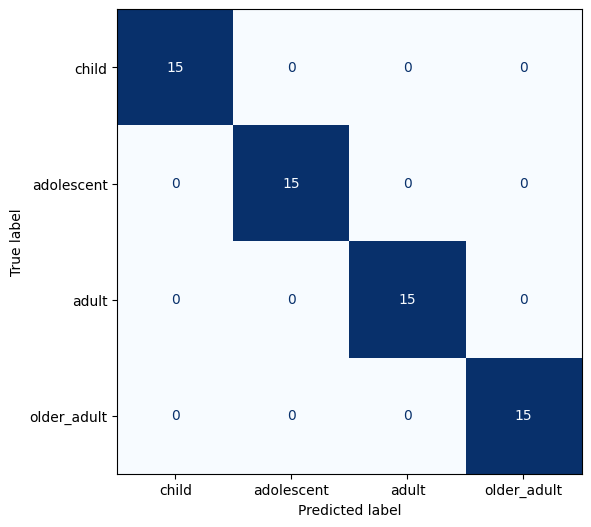

In [20]:
original_prompts = [p.original_prompt for p in classes]


original_preds, original_logits = collect_act_and_predict(model, tokenizer, original_prompts, probes_by_layer, args.target_layer, dtype, args.access_token, args.device_map, N=N)

original_pred_class = [t[i] for t in original_preds for i in range(len(t))]

original_true_class = [label_to_idx[p.age_class] for p in classes]*N

display_cm(original_true_class, original_pred_class, DEFAULT_AGE_LABELS)

## Confuse with appending prompt

In [21]:
def build_trigger_prompt(prompt: str, trigger_word: str) -> str:
  return prompt + " " + trigger_word

[tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0])]
[tensor([0, 0, 2, 3]), tensor([0, 0, 2, 3]), tensor([0, 0, 2, 3]), tensor([0, 0, 2, 3]), tensor([0, 0, 2, 3]), tensor([0, 0, 2, 3]), tensor([0, 0, 2, 3]), tensor([0, 0, 2, 3]), tensor([0, 0, 2, 3]), tensor([0, 0, 2, 3]), tensor([0, 0, 2, 3]), tensor([0, 0, 2, 3]), tensor([0, 0, 2, 3]), tensor([0, 0, 2, 3]), tensor([0, 0, 2, 3])]


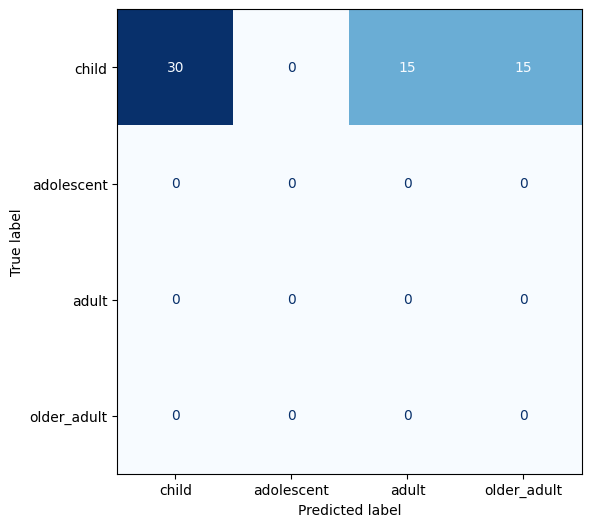

--------------------------------------------------------------------------------
[tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1])]
[tensor([1, 1, 1, 1]), tensor([1, 1, 1, 1]), tensor([1, 1, 1, 1]), tensor([1, 1, 1, 1]), tensor([1, 1, 1, 1]), tensor([1, 1, 1, 1]), tensor([1, 1, 1, 1]), tensor([1, 1, 1, 1]), tensor([1, 1, 1, 1]), tensor([1, 1, 1, 1]), tensor([1, 1, 1, 1]), tensor([1, 1, 1, 1]), tensor([1, 1, 1, 1]), tensor([1, 1, 1, 1]), tensor([1, 1, 1, 1])]


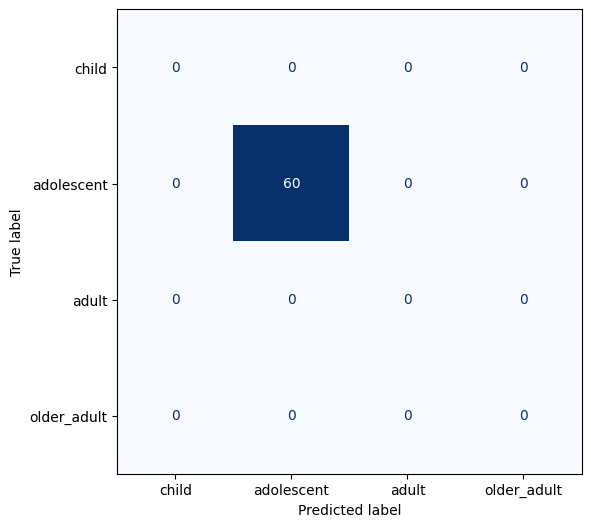

--------------------------------------------------------------------------------
[tensor([2]), tensor([2]), tensor([2]), tensor([2]), tensor([2]), tensor([2]), tensor([2]), tensor([2]), tensor([2]), tensor([2]), tensor([2]), tensor([2]), tensor([2]), tensor([2]), tensor([2])]
[tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3])]


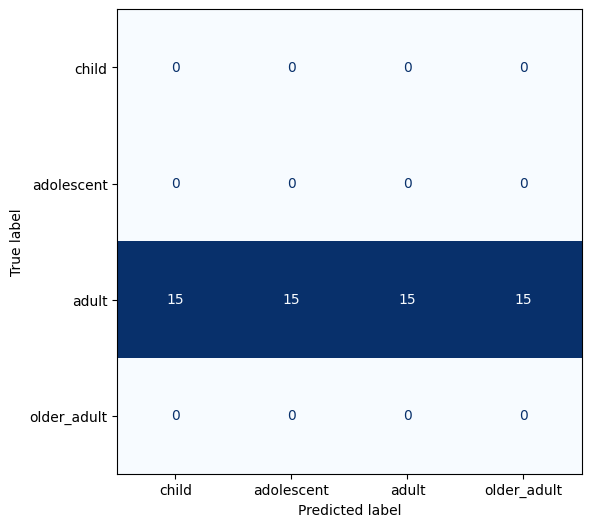

--------------------------------------------------------------------------------
[tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3])]
[tensor([3, 1, 3, 3]), tensor([3, 1, 3, 3]), tensor([3, 1, 3, 3]), tensor([3, 1, 3, 3]), tensor([3, 1, 3, 3]), tensor([3, 1, 3, 3]), tensor([3, 1, 3, 3]), tensor([3, 1, 3, 3]), tensor([3, 1, 3, 3]), tensor([3, 1, 3, 3]), tensor([3, 1, 3, 3]), tensor([3, 1, 3, 3]), tensor([3, 1, 3, 3]), tensor([3, 1, 3, 3]), tensor([3, 1, 3, 3])]


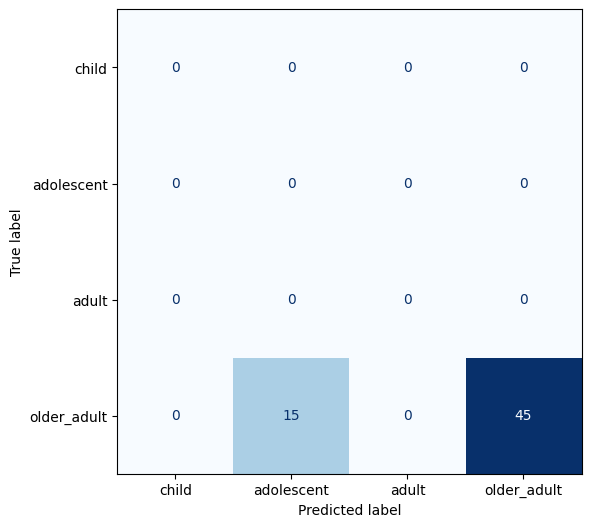

--------------------------------------------------------------------------------


In [22]:

for pair in classes:
    original_prompt = pair.original_prompt
    original_age_class = pair.age_class
    
    # print(f"Processing prompt: '{original_prompt}' (class: {original_age_class})")
    
    # Run original prompt N times
    original_preds, original_logits = collect_act_and_predict(
        model, tokenizer, [original_prompt], probes_by_layer, args.target_layer, 
        dtype, args.access_token, args.device_map, N=N
    )
    
    # Run with trigger words from other classes
    trigger_prompts = []
    for age_class in classes:
        if age_class != original_age_class:
            trigger_prompt = build_trigger_prompt(original_prompt, age_class.trigger_word)
            trigger_prompts.append(trigger_prompt)
    
    if trigger_prompts:
        trigger_preds, trigger_logits = collect_act_and_predict(
            model, tokenizer, trigger_prompts, probes_by_layer, args.target_layer,
            dtype, args.access_token, args.device_map, N=N
        )
        
        # Print results
        # print(f"Original logits across {N} runs: {original_logits}")
        # print(f"Trigger prompts: {trigger_prompts}")
        # print(f"Trigger logits across {N} runs: {trigger_logits}")
        
        # Show confusion matrix for all trigger predictions
        # Flatten the predictions to match the structure
        original_preds_flat = [pred for sublist in original_preds for pred in sublist]
        trigger_preds_flat = [pred for sublist in trigger_preds for pred in sublist]
        
        # Create true labels matching the flattened predictions
        y_true_original = [label_to_idx[original_age_class]] * len(original_preds_flat)
        y_true_trigger = [label_to_idx[original_age_class]] * len(trigger_preds_flat)
        
        display_cm(y_true_trigger, trigger_preds_flat, DEFAULT_AGE_LABELS)
    
    print("-" * 80)

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Collect confidence data for analysis
confidence_data = defaultdict(list)

for pair in classes:
    original_prompt = pair.original_prompt
    original_age_class = pair.age_class
    
    # Run original prompt N times
    original_preds, original_logits = collect_act_and_predict(
        model, tokenizer, [original_prompt], probes_by_layer, args.target_layer, 
        dtype, args.access_token, args.device_map, N=N
    )
    
    # Calculate average max confidence for original prompt
    original_max_confidences = []
    for logits_batch in original_logits:
        for logits in logits_batch:
            max_confidence = np.max(logits)
            original_max_confidences.append(max_confidence)
    
    original_avg_confidence = np.mean(original_max_confidences)
    
    # Run with trigger words from other classes
    for other_age_class in classes:
        if other_age_class != original_age_class:
            trigger_prompt = build_trigger_prompt(original_prompt, other_age_class.trigger_word)
            
            trigger_preds, trigger_logits = collect_act_and_predict(
                model, tokenizer, [trigger_prompt], probes_by_layer, args.target_layer,
                dtype, args.access_token, args.device_map, N=N
            )
            
            # Calculate average max confidence for trigger prompt
            trigger_max_confidences = []
            for logits_batch in trigger_logits:
                for logits in logits_batch:
                    max_confidence = np.max(logits)
                    trigger_max_confidences.append(max_confidence)
            
            trigger_avg_confidence = np.mean(trigger_max_confidences)
            
            # Store the confidence change
            confidence_change = trigger_avg_confidence - original_avg_confidence
            confidence_data[f"{original_age_class} → {other_age_class.age_class}"].append(confidence_change)

# Prepare data for plotting
perturbation_types = list(confidence_data.keys())
confidence_changes = [np.mean(confidence_data[ptype]) for ptype in perturbation_types]
confidence_stds = [np.std(confidence_data[ptype]) for ptype in perturbation_types]

# Create the plot
plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(perturbation_types)), confidence_changes, 
               yerr=confidence_stds, capsize=5, alpha=0.7)

# Color bars based on positive/negative changes
for i, (bar, change) in enumerate(zip(bars, confidence_changes)):
    if change > 0:
        bar.set_color('red')
    else:
        bar.set_color('blue')

plt.xlabel('Perturbation Type (Original → Trigger Class)')
plt.ylabel('Average Change in Max Confidence')
plt.title('Effect of Trigger Word Stuffing on Model Confidence')
plt.xticks(range(len(perturbation_types)), perturbation_types, rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("Confidence Change Summary:")
print("-" * 40)
for ptype in perturbation_types:
    mean_change = np.mean(confidence_data[ptype])
    std_change = np.std(confidence_data[ptype])
    print(f"{ptype}: {mean_change:.4f} ± {std_change:.4f}")


[tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0])]


TypeError: max() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis
